In [30]:
import os
import re
import json
import faiss
import numpy as np
import huggingface_hub
import matplotlib.pyplot as plt

from tqdm import tqdm
from openai import OpenAI
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from langchain.schema import Document
from langchain_community.vectorstores.faiss import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore

from dotenv import load_dotenv
load_dotenv("../keys.env")

openai_api_key = os.getenv('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key

hf_token = os.getenv("HF_TOKEN")
huggingface_hub.login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/pervinco/.cache/huggingface/token
Login successful


In [2]:
client = OpenAI()
model = "gpt-4o"

In [3]:
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

def load_document(path='../dataset/documents.jsonl'):
    raw_documents = load_jsonl(path)

    documents = []
    for doc in raw_documents:
        doc_id = doc['docid']
        content = doc['content']
        documents.append(Document(page_content=content, metadata={"docid": doc_id}))

    return documents

documents = load_document(path="../dataset/processed_documents.jsonl")

In [4]:
def clean_json_response(response):
    # 코드 블록(예: ```json, ```) 제거
    cleaned_response = re.sub(r'```(?:json)?', '', response).strip()
    return cleaned_response

In [23]:
def generate_keyword(document, model:str, client:OpenAI):
    prompt = (
        "당신은 주어진 문서를 읽고 이해하여 핵심을 파악하는 언어 전문가입니다. "
        "주어진 문서를 읽은 후에 문서와 관련성이 높은 하나의 질문을 생성한 후, 해당 문서에서 핵심이 되는 키워드 하나를 생성합니다. "
        "추가적으로 해당 문서가 어떤 분야에 해당하는지도 하나의 단어로 생성해야 합니다. "
        "반환하는 형식은 반드시 JSON 포맷이어야 하며, 모든 문자열은 쌍따옴표로 감싸야 합니다. "
        "형식은 다음과 같아야 합니다: "
        '{ "question": "생성한 질문", "keyword": "생성한 키워드", "domain": "생성한 분야" }. '
        "예를 들어: "
        '{ "question": "새의 얇은 부리는 어떤 상황에서 유용한가?", "keyword": "얇은 부리", "domain": "동물학" }.'
    )

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role" : "system", "content" : prompt},
            {"role" : "user", "content" : document}
        ],
    )
    
    response = completion.choices[0].message.content
    response = clean_json_response(response)
    
    try:
        json_response = json.loads(response)
    except json.JSONDecodeError:
        return {"error": "Invalid JSON response", "response": response}
    
    return json_response

In [24]:
sample_doc = documents[0]
print(sample_doc.page_content)

result = generate_keyword(sample_doc.page_content, model, client)
print(result)

건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 에너지 섭취와 에너지 소비의 수학적 동등성을 의미합니다. 일반적으로 건강한 사람은 1-2주의 기간 동안 에너지 균형을 달성합니다. 이 기간 동안에는 올바른 식단과 적절한 운동을 통해 에너지 섭취와 에너지 소비를 조절해야 합니다. 식단은 영양가 있는 식품을 포함하고, 적절한 칼로리를 섭취해야 합니다. 또한, 운동은 에너지 소비를 촉진시키고 근육을 강화시킵니다. 이렇게 에너지 균형을 유지하면 건강을 유지하고 비만이나 영양 실조와 같은 문제를 예방할 수 있습니다. 따라서 건강한 사람은 에너지 균형을 평형 상태로 유지하는 것이 중요하며, 이를 위해 1-2주의 기간 동안 식단과 운동을 조절해야 합니다.
{'question': '에너지 균형을 유지하기 위해 건강한 사람이 1-2주 동안 집중해야 할 두 가지 요소는 무엇인가요?', 'keyword': '에너지 균형', 'domain': '영양학'}


In [27]:
labeled_documents = []

for idx, doc in enumerate(documents):
    docid = doc.metadata.get('docid')
    content = doc.page_content
    print(f"{idx}\n{docid}\n{content}")

    result = generate_keyword(content, model, client)
    print(f"{result}\n") ## question, keyword
    
    if "keyword" in result and 'question' in result and 'domain' in result:
        doc.metadata["question"] = result["question"]
        doc.metadata["domain"] = result["domain"]
        doc.metadata["label"] = result["keyword"]
    else:
        doc.metadata['question'] = None
        doc.metadata["domain"] = None
        doc.metadata["label"] = None
    
    labeled_documents.append({
        "docid": doc.metadata["docid"],
        "content": doc.page_content,
        "domain" : doc.metadata['domain'],
        "question" : doc.metadata['question'],
        "label": doc.metadata["label"]
    })

0
42508ee0-c543-4338-878e-d98c6babee66
건강한 사람이 에너지 균형을 평형 상태로 유지하는 것은 중요합니다. 에너지 균형은 에너지 섭취와 에너지 소비의 수학적 동등성을 의미합니다. 일반적으로 건강한 사람은 1-2주의 기간 동안 에너지 균형을 달성합니다. 이 기간 동안에는 올바른 식단과 적절한 운동을 통해 에너지 섭취와 에너지 소비를 조절해야 합니다. 식단은 영양가 있는 식품을 포함하고, 적절한 칼로리를 섭취해야 합니다. 또한, 운동은 에너지 소비를 촉진시키고 근육을 강화시킵니다. 이렇게 에너지 균형을 유지하면 건강을 유지하고 비만이나 영양 실조와 같은 문제를 예방할 수 있습니다. 따라서 건강한 사람은 에너지 균형을 평형 상태로 유지하는 것이 중요하며, 이를 위해 1-2주의 기간 동안 식단과 운동을 조절해야 합니다.
{'question': '에너지 균형을 유지하기 위한 주요 요소는 무엇인가요?', 'keyword': '에너지 균형', 'domain': '건강'}

1
4a437e7f-16c1-4c62-96b9-f173d44f4339
수소, 산소, 질소 가스의 혼합물에서 평균 속도가 가장 빠른 분자는 수소입니다. 수소 분자는 가장 가볍고 작은 원자로 구성되어 있기 때문에 다른 분자들보다 더 빠르게 움직입니다. 이러한 이유로 수소 분자는 주어진 온도에서 가장 빠른 평균 속도를 가지고 있습니다. 수소 분자는 화학 반응에서도 활발하게 참여하며, 수소 연료로도 널리 사용됩니다. 따라서 수소 분자는 주어진 온도에서 평균 속도가 가장 빠른 분자입니다.
{'question': '왜 수소 분자는 산소나 질소보다 평균 속도가 빠른가?', 'keyword': '수소', 'domain': '화학'}

2
d3c68be5-9cb1-4d6e-ba18-5f81cf89affb
종이와 플라스틱은 재활용 가능한 자원입니다. 중학교 과학 수업에서 우리는 종이와 플라스틱 가방을 재활용하는 프로젝트를 진행하고 있습니다. 이 프로젝트를 통해 우리는 환경 보호의 중요성을 배

In [28]:
with open("../dataset/labeled_documents.jsonl", 'w', encoding='utf-8') as f:
    for entry in labeled_documents:
        json.dump(entry, f, ensure_ascii=False)
        f.write('\n')

In [31]:
model_name = "intfloat/multilingual-e5-large-instruct"
model_kwargs = {"device": "cuda:0"}
encode_kwargs = {"normalize_embeddings": False,
                    "clean_up_tokenization_spaces": True}

encoder = HuggingFaceEmbeddings(model_name=model_name,
                                model_kwargs=model_kwargs,
                                encode_kwargs=encode_kwargs)


def score_normalizer(val: float) -> float:
    return 1 / (1 + val)

index = faiss.IndexFlatL2(len(encoder.embed_query("파이썬")))

vector_store = FAISS(
    embedding_function=encoder,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
    relevance_score_fn=score_normalizer
)

vector_store.add_documents(documents=documents)
retrieval = vector_store

/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pervinco/miniconda3/envs/IR/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54805

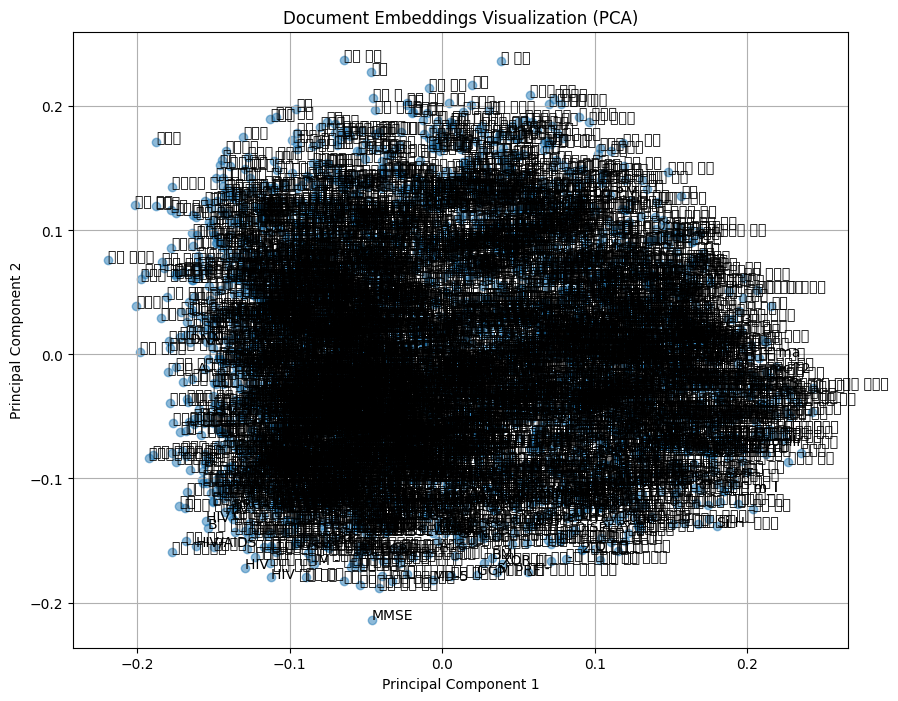

In [32]:
document_embeddings = []
for doc in documents:
    embedding = encoder.embed_query(doc.page_content)
    document_embeddings.append(embedding)


reduction_method = "PCA" ## PCA or t-SNE
if reduction_method == "PCA":
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(np.array(document_embeddings))

elif reduction_method == "t-SNE":
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    reduced_embeddings = tsne.fit_transform(np.array(document_embeddings))

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)

for i, doc in enumerate(documents):
    if doc.metadata.get("domain"):
        plt.annotate(doc.metadata["domain"], (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Document Embeddings Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()